In [1095]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [1377]:
df.isna().sum()

kwh                         0
solar_elevation            21
cloud_cover_fraction      187
dew_point                 266
humidity_fraction         266
precipitation           12217
pressure                14912
temperature               146
visibility                138
wind_speed                179
year                        0
month                       0
day                         0
hour                        0
dtype: int64

In [572]:
"""
Read in datasets and convert the datetime index to have a conformed dimension

"""

solar_prod = pd.read_csv('/Users/michaelyacobucci/Desktop/capstone/2015contest_CSV/solararray_production.csv')
solar_prod['Datetime'] = solar_prod.Date + ' ' + (solar_prod.Hour-1).astype(str) + ':00:00'
solar_prod['Datetime'] = pd.to_datetime(solar_prod.Datetime)#, format='%x %X')
solar_prod = solar_prod.set_index('Datetime')
solar_prod.drop(['Date','Hour'],axis=1,inplace=True)
solar_prod = solar_prod.resample('H').max()
#solar_prod.sort_index(inplace=True)


solar_elev = pd.read_csv('/Users/michaelyacobucci/Desktop/capstone/2015contest_CSV/solararray_solarangle.csv')
solar_elev['Datetime'] = solar_elev.Year.astype(str) +'/'+ \
                         solar_elev.Month.astype(str) +'/'+ \
                         solar_elev.Day.astype(str) +' '+ \
                         (solar_elev.Hour - 1).astype(str) +':00:00'
                        
solar_elev['Datetime'] = pd.to_datetime(solar_elev.Datetime)#, format='%x %X')
solar_elev = solar_elev.set_index('Datetime')
solar_elev.drop(['Location','Year', 'Month', 'Day','Hour'],axis=1,inplace=True)
solar_elev = solar_elev.resample('H').max() #double duty of removing the duplicated records
solar_elev.drop(solar_elev[solar_elev.index.min():solar_prod.index.min()].index, inplace = True)


solar_weat = pd.read_csv('/Users/michaelyacobucci/Desktop/capstone/2015contest_CSV/solararray_weather.csv')
solar_weat['Datetime'] = solar_weat.Year.astype(str) +'/'+ \
                         solar_weat.Month.astype(str) +'/'+ \
                         solar_weat.Day.astype(str) +' '+ \
                         solar_weat.Hour.astype(str) +':00:00'              
solar_weat['Datetime'] = pd.to_datetime(solar_weat.Datetime)#, format='%x %X')
solar_weat = solar_weat.set_index('Datetime')
solar_weat.drop(['Location','Year', 'Month', 'Day','Hour'],axis=1,inplace=True)
solar_weat = solar_weat.resample('H').max()
solar_weat.drop(solar_weat[solar_weat.index.min():solar_prod.index.min()-1].index, inplace = True)
solar_weat.drop(solar_weat[solar_prod.index.max()+1:solar_weat.index.max()].index, inplace = True)

print(solar_prod.index.min(), solar_prod.index.max())
print(solar_elev.index.min(), solar_elev.index.max())
print(solar_weat.index.min(), solar_weat.index.max())
print(len(solar_prod), len(solar_elev), len(solar_weat))



2010-01-04 15:00:00 2014-08-31 19:00:00
2010-01-04 16:00:00 2014-08-31 04:00:00
2010-01-04 15:00:00 2014-08-31 19:00:00
40805 40789 40805
40805


In [784]:
"""
Code to build a single dataframe object for our solar data
Also sets night time KWH to 0
"""

df = pd.concat([solar_prod, solar_elev, solar_weat], axis=1)
print(len(solar_df))
df.rename(columns={"Electricity_KW_HR": "kwh"},inplace=True)
df.rename(str.lower, axis='columns',inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

#create variables from lagged values
number_lags = 4
# for lag in range(1, number_lags + 1):
#     df['KWH_lag_' + str(lag)] = df.Wind_KWH.shift(lag)  
#     df['Wind_speed_lag_' + str(lag)] = df.Wind_Speed_AT_WINDFARM.shift(lag)
# df['kwh_30day_avg'] = df.Wind_KWH_lag_1.rolling('30D').mean()

#Set KWH to 0 for Night-time hours
df.loc[df.hour.isin((0,1,2,3,4,5,21,22,23)),'kwh'] = 0
df.loc[(df.hour == 6) & (df.month.isin((1,2,3,4,8,9,10,11,12))),'kwh'] = 0
df.loc[(df.hour == 7) & (df.month.isin((1,2,10,11,12))),'kwh'] = 0
df.loc[(df.hour == 8) & (df.month.isin((1,12))),'kwh'] = 0
df.loc[(df.hour == 20) & (df.month.isin((1,2,3,9,10,11,12))),'kwh'] = 0
df.loc[(df.hour == 19) & (df.month.isin((1,2,11,12))),'kwh'] = 0
df.loc[(df.hour == 18) & (df.month.isin((1,12))),'kwh'] = 0
df.loc[(df.hour == 17) & (df.month == 12),'kwh'] = 0


#Interpolate a few odd hours (with data from the same hour on). Note time change at hours 7 and 17
for h in (6,7,8,9,10,11,12,13,14,15,16,17,18,19,20):
     df.loc[(df.hour==h),'kwh'] = df.loc[(df.hour==h),'kwh'].interpolate()
df.kwh[(df.hour==17) & df.kwh.isna()] = 0 #few NaN at the start, just replacing them with 0


40805


In [1069]:
"""
Create a scaled dataframe
Create a dataframe with KNN imputed values
"""

# create a scaled version of the dataset
df_scaled = df.copy()
for c in df_scaled.columns:
    df_scaled[c] = (df_scaled[c] - df_scaled[c].min()) / (df_scaled[c].max() - df_scaled[c].min())


def knn_impute(dataframe,columns):
    """Function to use KNN to fill in NaN values
       NOTE: the dataframe should be scaled first.
       Returns a new DataFrame"""
    df = dataframe.copy()
    
    #grab each column
    for column in columns:

        train = df[~df[column].isna()].dropna()
        test = df[df[column].isna()]
        filled = df[column].isna()

        clf = KNeighborsRegressor(3, weights='distance')
        trained_model = clf.fit(train[df.columns.difference([column])], train[column])
        
        # Predict missing values' class
        imputed_values = trained_model.predict(test[df.columns.difference([column])].fillna(0))
        df.loc[filled, column] = imputed_values
        
    return df

#Best KNN values
# precipitation: (3, weights='uniform')

#Not sure what to do with these solar_kwh hours
df_scal_impu = knn_impute(df_scaled,df_scaled.columns[1:10]) #1,2,3,4,7,8,9 # lots of missing : 5,6
#df_scal_impu.isna().sum()

#smooth out the imputed years of 2013 and 2014 for presure
for y in (2013,2014):
    for m in range(1,12):
        df_scal_impu.pressure.loc[(df.year==y) & (df.month==m)] = \
        df_scal_impu.pressure.loc[(df.year==y) & (df.month==m)].rolling('24H').mean()

df_scal_impu['prev_day_kwh'] = df_scal_impu.kwh.shift(24)

In [14]:
?pd.DataFrame.drop

In [1368]:
"""
Functions for train/test splits

"""


def train_test_split_non_random(df,percent):
    "returns the first percent % as train and the rest as test "
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    split = int(len(df)*percent) #32644
    X1, X2 = X[:split], X[split:]
    y1, y2 = y[:split], y[split:]
    print('Persistence Model RMSE:', mean_squared_error(y2, y[split-1:-1])**.5)
    return X1, X2, y1, y2

def train_test_split_entire_days(df,percent):
    "returns the first percent % as train and the rest as test "
    
    first_hours = df.index[df.index.hour==0]
    starts = np.random.choice(np.arange(0,len(first_hours)), 
                              int(len(first_hours) * (1-percent)),
                              replace=False)
    test_idx = first_hours[starts]
    for i in range(1,24):
        temp = first_hours[starts] + pd.DateOffset(hours=i)
        test_idx = test_idx.append(temp)
    
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    
    test_idx = test_idx.sort_values()
    train_idx = X.index.difference(test_idx)

    X1, X2 = X.loc[train_idx], X.loc[test_idx]
    y1, y2 = y.loc[train_idx], y.loc[test_idx]

    return X1, X2, y1, y2

train_test_split_entire_days(df_scal_impu.dropna(),.8)

#df_scal_impu.kwh = df.kwh
# X1, X2, y1, y2 = train_test_split_non_random(df_scal_impu.dropna(),.8)
# X1, X2, y1, y2 = train_test_split(df_scal_impu.dropna().iloc[:,1:],df_scal_impu.dropna().iloc[:,0],train_size=.8)
X1, X2, y1, y2 = train_test_split_entire_days(df_scal_impu.dropna(),.8)

In [1246]:
"""kfold cross validate"""

seed = 42
k = 5
kfold = model_selection.KFold(n_splits=k, random_state=seed)
model = AdaBoostRegressor(n_estimators=1000, 
                          random_state=seed,
                          base_estimator=DecisionTreeRegressor(max_depth=3))#,loss='exponential')

results = model_selection.cross_val_score(model, X1, y1, cv=kfold, scoring='neg_mean_squared_error')
#predicts = model_selection.cross_val_predict(model,X1,y1,cv=kfold)
#print(((-results)**.5).mean())
print('Cross-Validated Avg RMSE:', np.average(-results, weights=np.repeat(1,k))**.5)
# (-results)**.5

Cross-Validated Avg RMSE: 0.11448332927178259


RMSE train:  0.11163663020784365
RMSE TEST:  0.11626268989197641


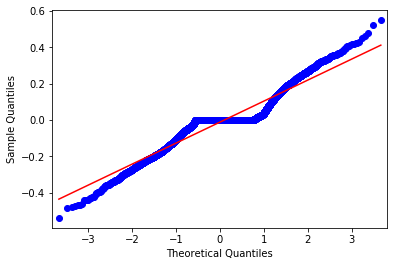

In [1369]:
"""Validate model"""

ada = model.fit(X1,y1)

# ada.feature_importances_
print('RMSE train: ', mean_squared_error(y1,ada.predict(X1))**.5)
# y1hat = ada.predict(X1)
# resid = y1-y1hat
# resid.hist();
# sm.qqplot(resid, line='s');
print('RMSE TEST: ', mean_squared_error(y2,ada.predict(X2))**.5)

y2hat = ada.predict(X2)
resid = y2-y2hat

# better_hist(resid,10)
sm.qqplot(resid, line='s');

df_pred = pd.DataFrame(y2)
df_pred['yhat'] = y2hat


In [1370]:
"""Most Important Features"""
pd.DataFrame( [X2.columns, model.feature_importances_]).T.sort_values(1)

,0,1
8,wind_speed,0
9,year,0.000784733
11,day,0.00117284
4,precipitation,0.00796784
7,visibility,0.00875747
6,temperature,0.00972341
5,pressure,0.0150881
10,month,0.0174861
2,dew_point,0.0408752
3,humidity_fraction,0.0611365


Datetime
2010    240
2011    281
2012    282
2013    291
2014    256
Name: kwh, dtype: int64
Datetime
2010    196
2011    195
2012    216
2013    196
2014    165
Name: kwh, dtype: int64


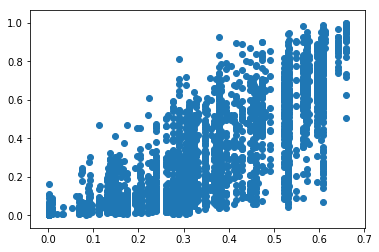

In [1376]:
#don't see any evidence of any years being worse than others
plt.scatter(df_pred.yhat,df_pred.kwh)
print(resid[resid<-.1].groupby(resid[resid<-.1].index.year).count())
print(resid[resid>.1].groupby(resid[resid>.1].index.year).count())

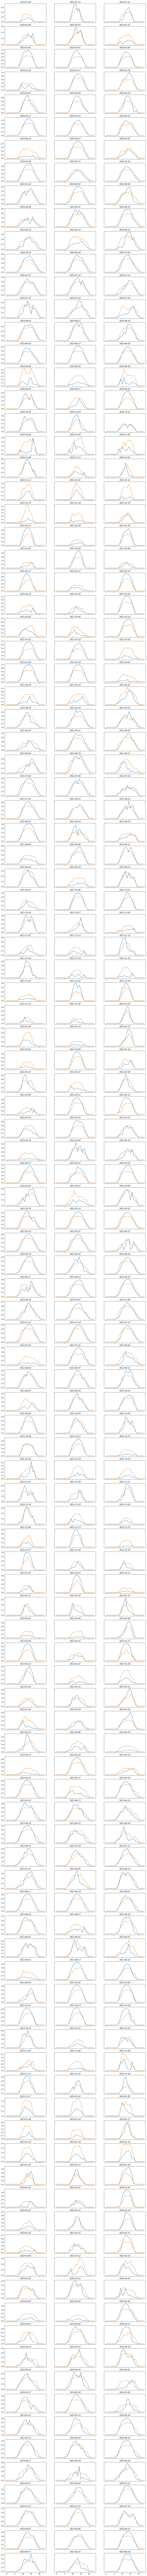

In [1375]:
"""
Plot our predictions (orange) vs true (blue) for each one of our test days.
"""
m = 113
n = 3
fig, ax = plt.subplots(m, n, sharex='col', sharey='row',figsize=(16,300))
# axes are in a two-dimensional array, indexed by [row, col]
idx = np.reshape(np.array(df_pred.index),(int(len(df_pred.index)/24),24))
ix = 0
for i in range(m):
    for j in range(n):
        ax[i, j].plot(df_pred.loc[idx[ix]].reset_index().drop('Datetime',axis=1))
        ax[i, j].set_title(str(df_pred.loc[idx[ix]].index.date[0]))
        ix +=1
fig
plt.show();